## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [1]:
%%capture
pip install shap tensorboard xbatcher

In [1]:
import os

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

import util

Changed working directory to /home/jovyan/ForestLST


/home/jovyan/ForestLST/util/__init__.py:17: UserWarning: Neither TensorFlow nor PyTorch found! Module util.training will not be loaded.
  warnings.warn("Neither TensorFlow nor PyTorch found! Module util.training will not be loaded.")


In [2]:
import os

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

import util

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

import shutil
import json
import random

from google.cloud.storage import Client

Changed working directory to /home/jovyan/ForestLST


/home/jovyan/ForestLST/util/__init__.py:22: UserWarning: Earth Engine API not found! Module util.gee will not be loaded.
  warnings.warn("Earth Engine API not found! Module util.gee will not be loaded.")


### Get data from GCS

In [2]:
ds = util.data.make_preisler_dataframe().reset_index()
ds.head()

,latitude,longitude,year,fire,mort,mort1,mtemp1,near1,prec1,prec2,prec3,prec4,prism_prec,rhost1
0,32.597501,-116.691155,2013,0.0,0.0,0.0,-0.216653,0.0000,369.805910,439.905603,480.046706,265.648307,415.772351,0.0
1,32.597501,-116.691155,2014,0.0,0.0,0.0,-2.696189,0.0000,247.394694,369.805910,439.905603,480.046706,415.772351,0.0
2,32.597501,-116.655223,2012,0.0,0.0,0.0,-1.278424,0.0000,448.261502,487.811619,267.075369,285.700573,417.824220,0.0
3,32.597501,-116.655223,2013,0.0,0.0,0.0,-0.367448,0.0000,364.210992,448.261502,487.811619,267.075369,417.824220,0.0
4,32.597501,-116.655223,2014,0.0,0.0,0.0,-3.270955,0.0016,257.534478,364.210992,448.261502,487.811619,417.824220,0.0


In [12]:
bbox = (
    ds.longitude.min(),
    ds.latitude.min(),
    ds.longitude.max(),
    ds.latitude.max()
)
print(bbox)

(-124.38073423918894, 32.59750092095032, -116.33182929347802, 42.00681264589888)


In [13]:
from pyproj import CRS, Transformer

crs_4326 = CRS("EPSG:4326")
crs_3857 = CRS("EPSG:3857")

tf = Transformer.from_crs(crs_4326, crs_3857, always_xy=True)

tf.transform_bounds(*bbox)

(-13845999.999999998,
 3841999.9999999986,
 -12949999.999999998,
 5162000.000000001)

In [15]:
import numpy as np

ca_bounds_3857 = tuple(map(np.round, tf.transform_bounds(*bbox)))

In [16]:
ca_bounds_3857

(-13846000.0, 3842000.0, -12950000.0, 5162000.0)

## Blocking data

Tree mortality exhibits spatial and temporal autocorrelation. That is, pixels that are close in space or close in time are more similar to each other. We must account for this in order to have a model that generalizes well. Preisler et al. (2017) and Rao et al. (2019) both used a random train/test split. This probably results in an overestimation of model performance on the test set. To quantify this effect we will test three splitting strategies:
 - Random
 - Spatial blocking
 - Temporal blocking

In each case, we will use a 70/30 train/valid split with two years of data held out for final testing. This mimics how this model would be used operationally to predict across all of California in the future.

Note that the data above have already been shifted such that this is a forecasting problem.

In [4]:
test_years = [2006, 2016]
trainval_idx = ds.year.isin(test_years)
ds_trainval = ds[~trainval_idx]
ds_test     = ds[ trainval_idx]

In [5]:
# Random split - this one is easy just call train_test_split twice
def random_split(df):
    train, valid = train_test_split(df, train_size=0.7, test_size=0.3)
    return train, valid

In [6]:
train, valid = random_split(ds_trainval)
assert train.shape[0] > valid.shape[0]

In [7]:
# Spatial split - group observations into 0.50-degree blocks and split
def spatial_split(df, coords=["latitude", "longitude"], blocksize=0.50):
    mindex = pd.MultiIndex.from_tuples(zip(*(
        np.round(df[c]/blocksize)*blocksize
        for c in coords
    )))

    # Unlike train_test_split, GroupShuffleSplit returns indices
    train_idx, valid_idx = next(GroupShuffleSplit(1, train_size=0.7, test_size=0.3).split(df, groups=mindex))

    return (
        df.iloc[train_idx], 
        df.iloc[valid_idx]
    )

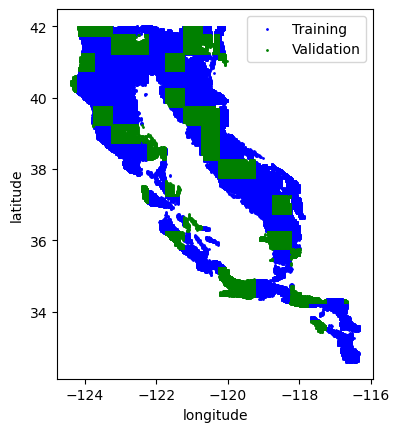

In [8]:
# Verify that it works
train, valid = spatial_split(ds_trainval)

fig, ax = plt.subplots(1, 1)

train.plot.scatter(x="longitude", y="latitude", s=1, ax=ax, label="Training", color="blue")
valid.plot.scatter(x="longitude", y="latitude", s=1, ax=ax, label="Validation", color="green")
ax.set_aspect("equal")
plt.show()

In [9]:
# Temporal split - just use GroupShuffleSplit with years instead of spatial blocks
def temporal_split(df, column="year"):
    # Unlike train_test_split, GroupShuffleSplit returns indices
    train_idx, valid_idx = next(GroupShuffleSplit(1, train_size=0.7, test_size=0.3).split(df, groups=df[column]))

    return (
        df.iloc[train_idx], 
        df.iloc[valid_idx]
    )

In [10]:
# Check that it works
train, valid = temporal_split(ds_trainval)

train_years = set(train["year"])
valid_years = set(valid["year"])

print("Years in training", train_years)
print("Years in validation", valid_years)

# Asserts to make sure we did it right
assert train_years.isdisjoint(valid_years)

Years in training {2019, 2020, 2021, 2022, 2004, 2007, 2008, 2010, 2012, 2013, 2014, 2015}
Years in validation {2017, 2018, 2023, 2005, 2009, 2011}


## Training workflow

Now that we have defined some ways of splitting data, we want to see how these influence model performance. We begin by defining a simple dense neural network with dropout. Since the output is between 0 and 1, the final layer gets a sigmoid activation function. Setting the initial bias to -2 helps convergence because `sigmoid(-2) ~= 0.1`, which approximates the mean of the data.

### Model definition

In [11]:
def make_simpledense(input_size, init_bias: float=None, dropout: float=0.2):
    m = torch.nn.Sequential(
        torch.nn.BatchNorm1d(input_size),
        torch.nn.Linear(input_size, 64),
        torch.nn.Dropout(p=dropout),
        torch.nn.Tanh(),
        torch.nn.Linear(64, 32),
        torch.nn.Dropout(p=dropout),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 8),
        torch.nn.Dropout(p=dropout),
        torch.nn.Tanh(),
        torch.nn.Linear(8, 1),
        torch.nn.Sigmoid()
    )

    if init_bias is not None:
        torch.nn.init.constant_(m[-2].bias, init_bias)

    return m

In [12]:
sd = make_simpledense(13, init_bias=1.0)
print(sd)

Sequential(
  (0): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=13, out_features=64, bias=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): Dropout(p=0.2, inplace=False)
  (6): Tanh()
  (7): Linear(in_features=32, out_features=8, bias=True)
  (8): Dropout(p=0.2, inplace=False)
  (9): Tanh()
  (10): Linear(in_features=8, out_features=1, bias=True)
  (11): Sigmoid()
)


### Convert inputs to tensors

In [13]:
TARGET = "mort"
EXCLUDE = ["year"]
BANDS = [c for c in ds.columns if c != TARGET and c not in EXCLUDE]

def df_to_dataloader(df):
    # Add two dimensions
    input = torch.from_numpy(df[BANDS].to_numpy().astype(np.float32))
    output = torch.unsqueeze(torch.from_numpy(df[TARGET].to_numpy().astype(np.float32)), 1)

    ds = TensorDataset(input, output)
    
    return DataLoader(ds, batch_size=512, shuffle=True)

### Training loop

In [14]:
from importlib import reload
reload(util.training)

<module 'util.training_torch' from '/home/jovyan/ForestLST/util/training_torch.py'>

In [15]:
class ReduceLRTrainer(util.training.BaseTrainer):
    def __init__(self, *args, **kwargs):
        super(ReduceLRTrainer, self).__init__(*args, **kwargs)

    def update_lr(self, train_loss, valid_loss):
        self._scheduler.step(valid_loss)

In [17]:
import torchmetrics

# Only doing temporal split since that makes the most
# sense here.
model_name = "preisler_simpledense"
train, valid = temporal_split(ds_trainval)
train_dl = df_to_dataloader(train)
valid_dl = df_to_dataloader(valid)

y_mean = train.mort.mean()
init_bias = np.log(y_mean / (1-y_mean))
n_feats = next(iter(train_dl))[0].shape[1]

model = make_simpledense(n_feats, dropout=0.5, init_bias=init_bias)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.2, patience=3)
loss = torch.nn.MSELoss()
metrics = [
    torchmetrics.regression.NormalizedRootMeanSquaredError(),
    torchmetrics.regression.R2Score()
]

trainer = ReduceLRTrainer(
    model,
    opt,
    scheduler,
    loss,
    train_dl,
    valid_dl,
    metrics=metrics,
    n_epochs=30,
    tensorboard_log=os.path.join("logs", model_name, "history"),
    model_log=os.path.join("logs", model_name, "model.pth")
)

trainer.train()

Epoch 1 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.009027
2                              Loss/valid  tensor(0.0119)
3  NormalizedRootMeanSquaredError()/train       2.7231762
4  NormalizedRootMeanSquaredError()/valid        2.422585
5                         R2Score()/train      0.16334265
6                         R2Score()/valid      0.15102774

Epoch 2 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.008731
2                              Loss/valid  tensor(0.0153)
3  NormalizedRootMeanSquaredError()/train       2.6772025
4  NormalizedRootMeanSquaredError()/valid        2.743206
5                         R2Score()/train      0.19135278
6                         R2Score()/valid     -0.08856022

Epoch 3 of 30
                            

## Visualize results

### Learning curves

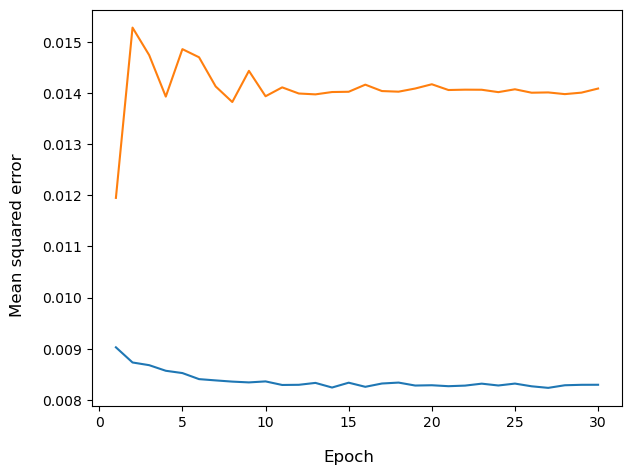

In [18]:
def learning_curve(loss, val_loss, ax):
    epoch = 1+np.arange(len(loss))

    ax.plot(epoch, loss, label="training")
    ax.plot(epoch, val_loss, label="validation")

fig, ax = plt.subplots()

learning_curve(
    trainer.history["Loss/train"],
    trainer.history["Loss/valid"],
    ax
)


fig.supxlabel("Epoch", y=0.02, x=0.55)
fig.supylabel("Mean squared error")

plt.tight_layout()
plt.show()

### Test data one-to-one

In [19]:
X_test = torch.from_numpy(ds_test[BANDS].to_numpy().astype(np.float32))
y_actual = ds_test["mort"].to_numpy()

trainer._model.eval()
with torch.no_grad():
    y_hat = trainer._model(X_test).numpy()[:, 0]

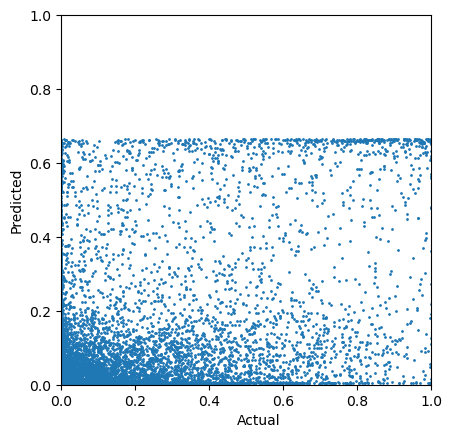

In [20]:
def one_to_one_plot(y_actual, y_predicted, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
        
    ax.scatter(y_actual, y_predicted, **kwargs)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    return ax

fig, ax = plt.subplots()

scatter_args = dict(s=1)

one_to_one_plot(y_actual, y_hat, ax=ax, **scatter_args)

plt.xlabel("Actual", y=0.03, x=0.535)
plt.ylabel("Predicted")

plt.show()

### Performance metrics

In [21]:
nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError()
nmrse_hat = nrmse(torch.from_numpy(y_actual), torch.from_numpy(y_hat)).item()

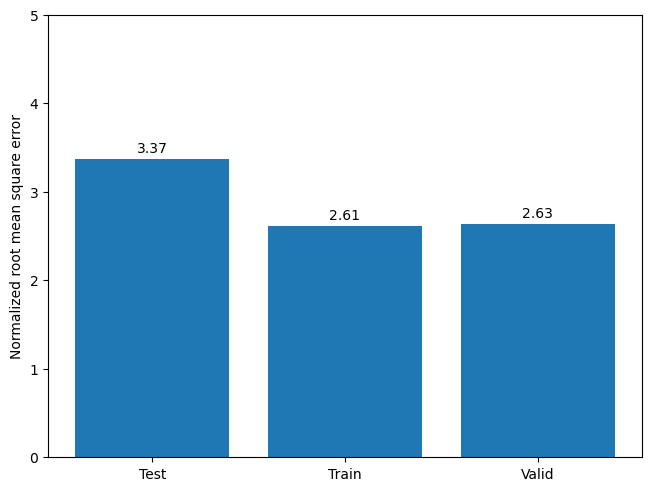

In [22]:
fig, ax = plt.subplots(layout='constrained')

metrics = {
    "Test": nmrse_hat,
    "Train": trainer.history["NormalizedRootMeanSquaredError()/train"][-1],
    "Valid": trainer.history["NormalizedRootMeanSquaredError()/valid"][-1]
}

rects = ax.bar(metrics.keys(), metrics.values())
ax.bar_label(rects, padding=3, fmt="{:.2f}")
ax.set_ylabel("Normalized root mean square error")
ax.set_ylim(0, 5)
plt.show()

### Map of test predictions by strategy

In [23]:
ds_test = ds_test.copy()
ds_test["mort_predict"] = y_hat

ds_test_xr = ds_test.set_index(["latitude", "longitude", "year"]).to_xarray()

In [24]:
ds_test_xr

<xarray.Dataset> Size: 14MB
Dimensions:       (latitude: 329, longitude: 224, year: 2)
Coordinates:
  * latitude      (latitude) float64 3kB 32.66 32.69 32.72 ... 41.95 41.98 42.01
  * longitude     (longitude) float64 2kB -124.3 -124.3 -124.3 ... -116.4 -116.3
  * year          (year) int64 16B 2006 2016
Data variables:
    fire          (latitude, longitude, year) float64 1MB nan nan ... nan nan
    mort          (latitude, longitude, year) float64 1MB nan nan ... nan nan
    mort1         (latitude, longitude, year) float64 1MB nan nan ... nan nan
    mtemp1        (latitude, longitude, year) float64 1MB nan nan ... nan nan
    near1         (latitude, longitude, year) float64 1MB nan nan ... nan nan
    prec1         (latitude, longitude, year) float64 1MB nan nan ... nan nan
    prec2         (latitude, longitude, year) float64 1MB nan nan ... nan nan
    prec3         (latitude, longitude, year) float64 1MB nan nan ... nan nan
    prec4         (latitude, longitude, year) float64 1MB nan nan ... nan nan
    prism_prec    (latitude, longitude, year) float64 1MB nan nan ... nan nan
    rhost1        (latitude, longitude, year) float64 1MB nan nan ... nan nan
    mort_predict  (latitude, longitude, year) float32 590kB nan nan ... nan nan

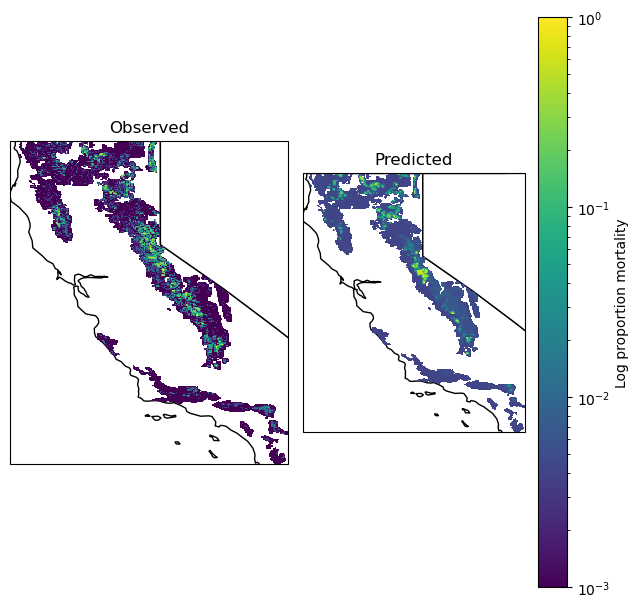

In [25]:
from matplotlib.colors import LogNorm
import cartopy.feature as cfeature

mercator_proj = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 2, figsize=(6, 6), subplot_kw=dict(projection=mercator_proj))


# Add state borders
state_borders = cfeature.NaturalEarthFeature(
    category='cultural', 
    name='admin_1_states_provinces_lakes', 
    scale='50m', facecolor='#FFFFFF'
)

for a in ax.ravel():
    a.add_feature(state_borders, edgecolor="black", zorder=0)

# Draw predictions
eps = 1e-3
norm = LogNorm(vmin=eps, vmax=1)

_  = (ds_test_xr.mort + eps).isel(year=0).plot(x="longitude", y="latitude", ax=ax[0], norm=norm, add_colorbar=False)
im  = (ds_test_xr.mort_predict + eps).isel(year=0).plot(x="longitude", y="latitude", ax=ax[1], norm=norm, add_colorbar=False)

plt.tight_layout()
fig.colorbar(im, ax=ax[1], location="right", label="Log proportion mortality")

# Labels
ax[0].set_title("Observed")
ax[1].set_title("Predicted")

plt.show()

### SHAP

In [100]:
import shap
from shap import DeepExplainer, KernelExplainer

# Do SHAP in log space
eps = 1e-3
data = torch.tensor(train[::1000][BANDS].to_numpy()).type(torch.float32)

model_lambda = lambda X: np.log10(trainer._model(torch.tensor(X)).numpy() + eps)

display_names = ["Latitude", "Longitude", "Fire area", 
                 "% Mortality, 1-year lag", "Winter Tmin, 1-year lag", 
                 "% Nearby mortality, 1-year lag", "Precip, 1-year lag", 
                 "Precip, 2-year lag", "Precip, 3-year lag", 
                 "Precip, 4-year lag", "36-year avg precip", 
                 "% Forest area"]

trainer._model.eval()
with torch.no_grad():
    de = DeepExplainer(trainer._model, data)
    ke = KernelExplainer(model_lambda, data.numpy(), feature_names=display_names)

shap_values = de.shap_values(data)

with torch.no_grad():
    shap_explainer = ke(data.numpy())

Using 148 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/148 [00:00<?, ?it/s]

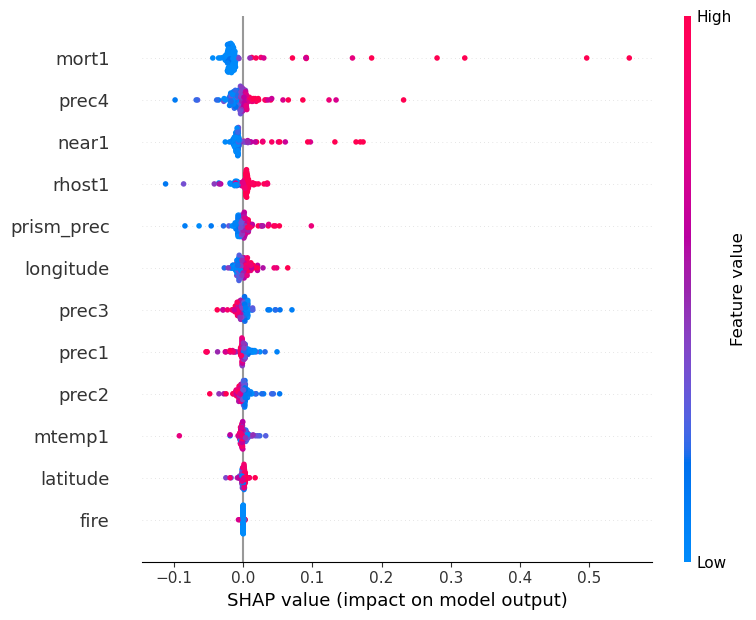

In [101]:
shap.summary_plot(shap_values[:, :, 0], data, BANDS)

In [107]:
# In log space
shap.waterfall_plot(shap_explainer[20, :, 0], max_display=5, show=False)
p = plt.gcf()

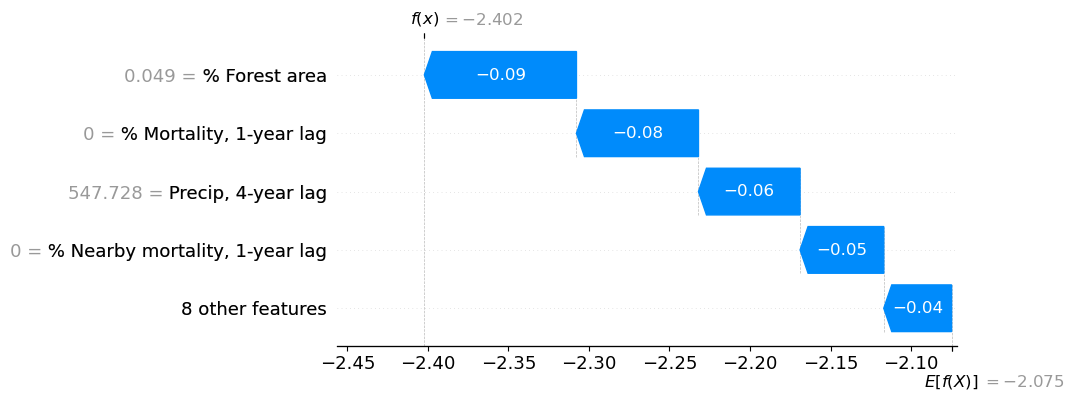

In [108]:
p

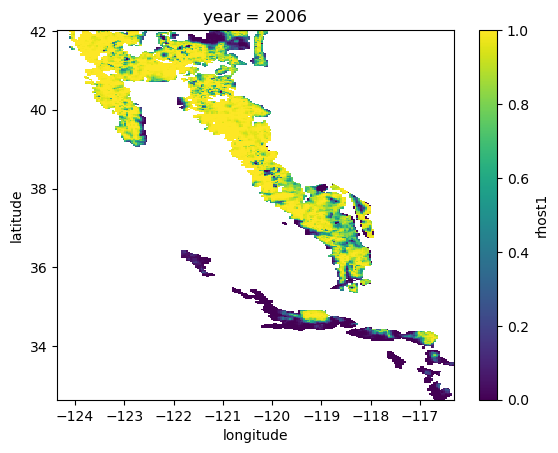

In [94]:
ds_test_xr.rhost1.isel(year=0).plot()

### Modeling extents

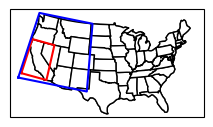

In [85]:
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches

west_xmin, west_ymin, west_xmax, west_ymax = (-124.83182873097032, 31.31942505180775, -103.62260487290841, 49.0320562417854)

ca_xmin, ca_ymin, ca_xmax, ca_ymax = (
    ds_test_xr.longitude.min().values,
    ds_test_xr.latitude.min().values,
    ds_test_xr.longitude.max().values,
    ds_test_xr.latitude.max().values
)

fig = plt.figure(figsize=(2.5, 1.5))
ax = plt.axes(projection=ccrs.LambertConformal())

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(
    resolution='110m',
    category='cultural', 
    name=shapename
)

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=lambda x: {"facecolor": "#FFFFFF", "edgecolor": "black"}
)

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=lambda x: {"facecolor": "#FFFFFF", "edgecolor": "black"}
)

ax.plot(
    [ca_xmin, ca_xmax, ca_xmax, ca_xmin, ca_xmin],
    [ca_ymin, ca_ymin, ca_ymax, ca_ymax, ca_ymin],
    color="red",
    linewidth=1.5,
    transform=ccrs.Geodetic(),
    label="ca mort"
)


ax.plot(
    [west_xmin, west_xmax, west_xmax, west_xmin, west_xmin],
    [west_ymin, west_ymin, west_ymax, west_ymax, west_ymin],
    color="blue",
    linewidth=1.5,
    transform=ccrs.Geodetic(),
    label="west mort"
)

ax.set_extent([-125, -70, 25, 50], crs=ccrs.PlateCarree())
# plt.legend(loc="lower left")
plt.savefig(fname="extents.png", dpi=150)